# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [OUMOUHOU Hicham 1](https://github.com/hichamomh)
- [CHADLI Mohammed Amine 2](https://github.com/MACnCH)

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [1]:
%load_ext autoreload
%autoreload 2


## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

In [81]:
import numpy as np
train = np.loadtxt('data/synth_train.txt')
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]


In [82]:
test = np.loadtxt('data/synth_test.txt')
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]


1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

Text(0, 0.5, 'y')

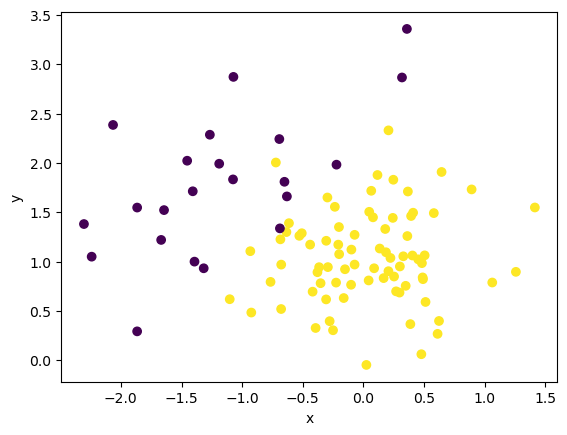

In [83]:
import matplotlib.pyplot as plt
plt.scatter(x_train[:,0], x_train[:,1], c=class_train)
plt.xlabel("x")
plt.ylabel("y")


2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


**Answer:**

In [347]:
def numpy_knn(x_train, class_train, x_test, k):
    """
    x_train: training data
    class_train: class of training data
    x_test: test data
    k: number of neighbours to consider
    """
    N_test = x_test.shape[0]
    N_train = x_train.shape[0]
    class_test = np.zeros(N_test).astype(int)
    for i in range(N_test):
        dist = np.sum((x_train - x_test[i,:])**2, axis=1)
        idx = np.argsort(dist)[:k]
        class_test[i] = np.argmax(np.bincount(class_train[idx].astype(int)))
    return class_test


In [348]:
import numpy as np
from scipy.stats import mode

def naive_knn(x_train, class_train, x_test, k):
    N_test = x_test.shape[0]
    N_train = x_train.shape[0]
    class_test = np.zeros(N_test, dtype=int)

    for i in range(N_test):
        distances = np.zeros(N_train, dtype=float)
        for j in range(N_train):
            dist = 0
            for d in range(x_train.shape[1]):
                diff = x_train[j, d] - x_test[i, d]
                dist += diff * diff
            distances[j] = dist

        # Find indices of k nearest neighbors
        idx = np.argsort(distances)[:k]

        # Calculate the mode of the k nearest neighbor classes
        mode_class = int(mode(class_train[idx])[0])
        class_test[i] = mode_class

    return class_test


3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

Time:  1.4125048000023526


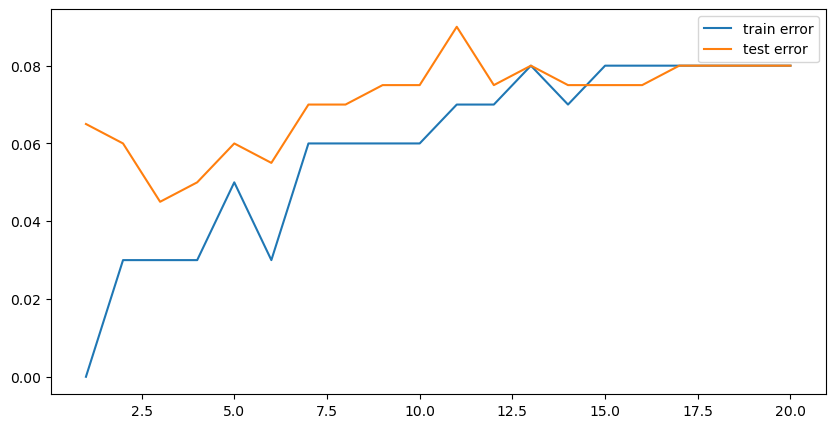

In [349]:
train_error = np.zeros(20)
test_error = np.zeros(20)
import timeit
start = timeit.default_timer()
for k in range(1,21):
    pred_class_train = naive_knn(x_train, class_train, x_train, k)
    train_error[k-1] = np.mean(pred_class_train != class_train.astype(int))
    pred_class_test = naive_knn(x_train, class_train, x_test, k)
    test_error[k-1] = np.mean(pred_class_test != test[:,0].astype(int))

stop = timeit.default_timer()

print('Time: ', stop - start)
plt.figure(figsize=(10,5))
plt.plot(range(1,21), train_error, label="train error")
plt.plot(range(1,21), test_error, label="test error")
plt.legend()


4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

On remarque que l'erreur sur le jeu de test est minimale pour K=3. Cependant, on remarque que l'erreur sur le jeu d'apprentissage est nulle pour K=1 (ce qui est previsible). Cela signifie que le modèle est sur-apprentissé. On peut donc choisir K=3 qui est un bon compromis entre les deux.

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

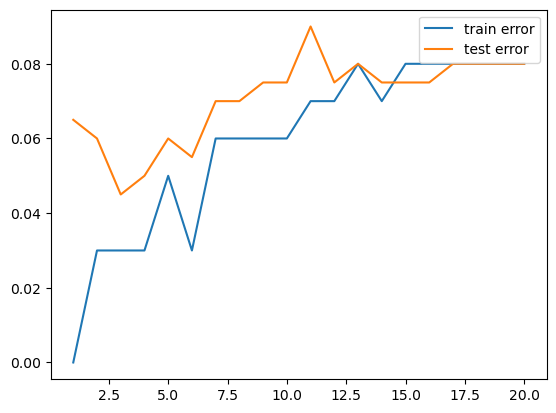

In [361]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import sklearn
from sklearn import neighbors

test_error = np.zeros(20)
train_error = np.zeros(20)

for k in range(1,21):
    knn_sklearn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_sklearn.fit(x_train, class_train)
    pred_class_train = knn_sklearn.predict(x_train)
    pred_class_test = knn_sklearn.predict(x_test)
    test_error[k-1] = np.mean(pred_class_test != test[:,0])
    train_error[k-1] = np.mean(pred_class_train != class_train)

plt.plot(range(1,21), train_error, label="train error")
plt.plot(range(1,21), test_error, label="test error")
plt.legend()


In [379]:
numpy_time = timeit.timeit(lambda: numpy_knn(x_train, class_train, x_test,5), number=50)
naive_time = timeit.timeit(lambda: naive_knn(x_train, class_train, x_test,5), number=50)
sklearn_time = timeit.timeit(lambda: knn_sklearn.predict(x_test), number=50)

print("numpy time: ", numpy_time)
print("naive time: ", naive_time)
print("sklearn time: ", sklearn_time)


numpy time:  0.16093149999869638
naive time:  2.588010799998301
sklearn time:  0.23377840000102879


On remarque d'abord que les résultats sont identiques. Ensuite, on remarque que le temps d'exécution de la fonction implémentée de manière naive  est plus long que celui de la fonction de sklearn. Cela est dû au fait que la fonction de sklearn est optimisée et que la notre ne l'est pas. Mais en utisant le calcule vectoriele de numpy (numpy.sum()) on peut sur performer le modèle sklearn et cela peut etre expliquer par le fait ce modèle contient plus de fonctionnalité (les probabilités...).
mais on peut encore l'optimiser en utilisant Cython ou Numba.

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

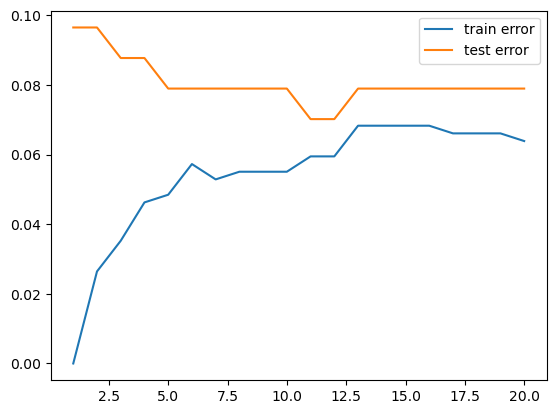

In [383]:
import pandas as pd
data = pd.read_csv("data/wdbc12.data.txt")
X = data.iloc[:,2:].values
Y = data.iloc[:,1].values

x_train_real, x_test_real, class_train_real, class_test_real = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

test_error = np.zeros(20)
train_error = np.zeros(20)


for k in range(1,21):
    knn_sklearn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_sklearn.fit(x_train_real, class_train_real)
    pred_class_train = knn_sklearn.predict(x_train_real)
    pred_class_test = knn_sklearn.predict(x_test_real)
    test_error[k-1] = np.mean(pred_class_test != class_test_real)
    train_error[k-1] = np.mean(pred_class_train != class_train_real)

plt.plot(range(1,21), train_error, label="train error")
plt.plot(range(1,21), test_error, label="test error")
plt.legend()


## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [73]:
!cd example_cy && python setup.py build_ext --inplace


running build_ext
building 'example_cy.helloworld' extension
"C:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.37.32822\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -Ic:\Users\hicha\anaconda3\include -Ic:\Users\hicha\anaconda3\Include "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.37.32822\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\um" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\shared" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\winrt" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\cppwinrt" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.8\include\um" /Tchelloworld.c /Fobuild\temp.win-amd64-cpython-39\Release\helloworld.obj
helloworld.c
creating g:\Mon Dr

In [75]:
import example_cy.build.example_cy.helloworld as toy

toy.printhello()


Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [89]:
!cd example_np_cy && python setup.py build_ext --inplace


running build_ext
copying build\lib.win-amd64-cpython-39\compute_cy.cp39-win_amd64.pyd -> 


In [90]:
import example_np_cy.compute as compute

array_1 = np.random.randint(0, 20, (100, 100))
array_2 = np.random.randint(0, 20, (100, 100))
a = 2
b = 3
c = 4
result = compute.compute(array_1, array_2, a, b, c)
print(result)


[[42 17 60 ... 54 66 59]
 [64 33 78 ... 34 51 69]
 [34 42 53 ... 60 32 60]
 ...
 [69 81 55 ... 54 62 78]
 [30 78 54 ... 67 54 66]
 [33 46 63 ... 42 17 81]]


3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [266]:
!cd KNN && python setup.py build_ext --inplace


Compiling knn.pyx because it changed.
[1/1] Cythonizing knn.pyx
running build_ext
building 'KNN.knn' extension
"C:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.37.32822\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -Ic:\Users\hicha\anaconda3\lib\site-packages\numpy\core\include -Ic:\Users\hicha\anaconda3\include -Ic:\Users\hicha\anaconda3\Include "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.37.32822\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\um" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\shared" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\winrt" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\cppwinrt" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.8\inc

c:\Users\hicha\anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: g:\Mon Drive\G3\Python\Centrale-Lille-Python\Labs\Lab4\KNN\knn.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [267]:
import KNN.knn as cknn
cknn.knn(x_train, class_train, x_test,5)


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1,
       2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 1])

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [375]:
cython_time = timeit.timeit(lambda: cknn.knn(x_train, class_train, x_test,5), number=50)
numpy_time = timeit.timeit(lambda: numpy_knn(x_train, class_train, x_test,5), number=50)
naive_time = timeit.timeit(lambda: naive_knn(x_train, class_train, x_test,5), number=50)


In [376]:
print("Cython time: ", cython_time)
print("Numpy time : ", numpy_time)
print("Naive time: ", naive_time)


Cython time:  0.1445888999987801
Numpy time :  0.14382409999961965
Naive time:  2.2501206000015372


On constate que la version naïve de la fonction a un temps d'exécution plus long que les autres. Cependant, la puissance de Cython se révèle dans l'amélioration significative du temps d'exécution de cette fonction, lui permettant d'atteindre des performances comparables à celles de la fonction NumPy. On peut donc conclure que Cython est un outil très utile pour optimiser les performances de nos codes (surtout les code no numpy).

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

Remarque : pour voir les effets de numba, j'ai changé un peu le code de les fonctions gradient2D et TV en utilisant des boucles for au lieu des  fonction numpy(numpy.c_...)

In [384]:
import numpy as np

def gradient2D_with_loops(X):
    assert X.ndim == 2, 'The input array must be 2D'
    rows, cols = X.shape

    Yh = np.zeros_like(X)
    Yv = np.zeros_like(X)


    for i in range(rows):
        for j in range(cols - 1):
            Yh[i, j] = X[i, j+1] - X[i, j]


    for i in range(rows - 1):
        for j in range(cols):
            Yv[i, j] = X[i+1, j] - X[i, j]

    return Yh, Yv

def TV_with_loops(X):
    assert X.ndim == 2, 'The input array must be 2D'

    Yh, Yv = gradient2D_with_loops(X)

    squared_sum_tv = 0
    rows, cols = X.shape
    for i in range(rows):
        for j in range(cols):
            squared_sum_tv += Yh[i, j] ** 2 + Yv[i, j] ** 2

    squared_sum_tv = np.sqrt(squared_sum_tv)

    return squared_sum_tv


In [385]:
import timeit
X  = np.random.randint(0, 50, (300, 300))
time_execution = timeit.timeit(lambda: TV_with_loops(X), number=10)
print('Time taken by the function with loops: {:.4f} seconds'.format(time_execution))


Time taken by the function with loops: 1.0971 seconds


2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [391]:
import numpy as np
from numba import jit, njit
import time

@jit(nopython=True)
def gradient2D_with_loops(X):
    assert X.ndim == 2, 'The input array must be 2D'
    rows, cols = X.shape

    Yh = np.zeros_like(X)
    Yv = np.zeros_like(X)

    for i in range(rows):
        for j in range(cols - 1):
            Yh[i, j] = X[i, j+1] - X[i, j]

    for i in range(rows - 1):
        for j in range(cols):
            Yv[i, j] = X[i+1, j] - X[i, j]

    return Yh, Yv

# on a utilisé le mode fastmath=True pour accélérer le calcul vu qu'on calcule des carrés.
@njit(fastmath=True)
def TV_with_loops(X):
    assert X.ndim == 2, 'The input array must be 2D'


    Yh, Yv = gradient2D_with_loops(X)


    squared_sum_tv = 0
    rows, cols = X.shape
    for i in range(rows):
        for j in range(cols):
            squared_sum_tv += Yh[i, j] ** 2 + Yv[i, j] ** 2

    squared_sum_tv = np.sqrt(squared_sum_tv)

    return squared_sum_tv


In [389]:
start = time.time()
TV_with_loops(X)
end = time.time()
print(" Compilation = %s" % (end - start))


 Compilation = 0.3602724075317383


In [390]:

new_time_execution = timeit.timeit(lambda: TV_with_loops(X), number=10)
rapport = time_execution/new_time_execution
print('without loops: {:.4f} seconds'.format(time_execution))
print('with numba: {:.4f} seconds'.format(new_time_execution))
print(f'Rapport: {rapport} !!!')


without loops: 1.0971 seconds
with numba: 0.0030 seconds
Rapport: 368.4742553523047 !!!


On remarque que la version numba est plus rapide que la version numpy. Cela est dû au fait que numba compile le code python en code machine.